<a href="https://colab.research.google.com/github/Mobashera-Alam/CS-5783-MachineLearning/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename_x_train = "/content/drive/My Drive/ML/Assignment 2/X_train.csv"
filename_y_train = "/content/drive/My Drive/ML/Assignment 2/Y_train.csv"
filename_x_test = "/content/drive/My Drive/ML/Assignment 2/X_test.csv"
filename_y_test = "/content/drive/My Drive/ML/Assignment 2/Y_test.csv"
X_train = pd.DataFrame()
Y_train = pd.DataFrame()
X_train = pd.read_csv(filename_x_train, delim_whitespace = True)
Y_train = pd.read_csv(filename_y_train, delim_whitespace = True)
X_test = pd.read_csv(filename_x_test, delim_whitespace = True)
Y_test = pd.read_csv(filename_y_test, delim_whitespace = True)
X = np.array(X_train)
Y = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


1. This is a linear regression problem so we choose identity function as activation funciton in output layer.

2. Since output layers has one column (label) so we will need one neuron at output layer to match the dimension. 

In [58]:
#Activation function
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

In [5]:
#Shape of layer
def layer_sizes(X, Y):
    n_x = X.shape[0] # size of input layer
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_y)

In [6]:
def init_params(n_x, n_h, n_y):
    W1 = np.random.randn(n_h,n_x) * 0.1
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.1
    b2 = np.zeros((n_y,1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

In [54]:
def forward_propagation(X, parameters, activation):
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1,X) + b1

    if activation == "sigmoid":
        A1 = sigmoid(Z1)
    elif activation == "relu":
        
        A1 = relu(Z1)
    elif activation == "tanh":
        A1 = np.tanh(Z1)
    else:
        A1 = sigmoid(Z1)
    print("A1 = ", A1.shape)
    Z2 = np.dot(W2,A1) + b2
    A2 = Z2

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [8]:
def compute_cost(A2, Y, parameters):
    
    m = Y.shape[1] # number of example

    #MSE
    cost = (1/m) * (Y - A2) @ (Y - A2).T
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. E.g., turns [[17]] into 17
    return cost

In [42]:
def backward_propagation(parameters, cache, X, Y, activation):

    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2,A1.T)
    db2 = (1/m) *(np.sum(dZ2,axis=1,keepdims=True))

    if activation == "sigmoid":
        dZ1 = np.dot(W2.T,dZ2) * sigmoid(Z1) * (1 - sigmoid(Z1))
    elif activation == "relu":
        dZ1 = np.dot(W2.T,dZ2)
        dZ1[Z1 <= 0.0] = 0.0
    elif activation == "tanh":
        dZ1 = np.dot(W2.T,dZ2) * (1 - np.tanh(Z1)*np.tanh(Z1))
    else:
        dZ1 = np.dot(W2.T,dZ2) * sigmoid(Z1) * (1 - sigmoid(Z1))

    dW1 = (1/m) *(np.dot(dZ1,X.T))
    db1 = (1/m) *(np.sum(dZ1, axis=1, keepdims=True))
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [10]:
def update_parameters(parameters, grads, learning_rate):

    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


In [45]:
def MLP_model(X, Y, n_h, learning_rate, activation, num_iterations = 1000, print_cost=False):
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[1]
    
    # Initialize parameters
    parameters = init_params(n_x, n_h, n_y)
    
    cost_tot = []
    # Loop (gradient descent)
    
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A2, cache = forward_propagation(X, parameters, activation)

        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost"
        cost = compute_cost(A2, Y, parameters)

        cost_tot.append(cost)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads"
        
        grads = backward_propagation(parameters, cache, X, Y, activation)
        
        # Update rule for each parameter
        parameters = update_parameters(parameters, grads, learning_rate)
        # If print_cost=True, Print the cost every 1000 iterations
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    # Returns parameters learnt by the model. They can then be used to predict output
    return parameters, cost_tot


In [12]:
def predict(parameters, X, activation):
    A2, cache = forward_propagation(X, parameters, activation)
    return A2

In [13]:
def plot_cost(cost_tot, num_epochs):
	plt.xlabel('Number of Iterations')
	plt.ylabel('Loss')
	plt.plot(np.arange(num_epochs), cost_tot)
	plt.show()

In [14]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtrain - meanX) / stdX
    xtestSt = xtestSt.T
    ytestSt = (ytrain - meanY) / stdY
    ytestSt = ytestSt.T
    epochs=1000
    lr = 0.1
    activation = "sigmoid"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 2, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

    

    ytestHatSt = predict(parameters, xtestSt, activation)
    #Back to original data
    error = np.sqrt(((ytestHatSt - ytestSt) ** 2).mean())
    print(error)
    

   

if __name__ == "__main__":
    main()

Cost after iteration 0: 1.002786
Cost after iteration 500: 0.021783
W1 = [[-0.08740204 -1.34046702]
 [ 0.10931932 -1.25500428]]
b1 = [[ 0.00373222]
 [-0.0060436 ]]
W2 = [[-2.08075326 -1.69290456]]
b2 = [[1.89024395]]
0.11793397459814868


3. MSE loss =  0.1055994247979705(Will vary for each run) for learning rate = 0.1 on training set. And MSE =0.09982126929708558 on test set. 

Cost after iteration 0: 0.995879
Cost after iteration 500: 0.993919
Cost after iteration 1000: 0.992055
Cost after iteration 0: 1.000301
Cost after iteration 500: 0.994186
Cost after iteration 1000: 0.944485
Cost after iteration 0: 0.989666
Cost after iteration 500: 0.014053
Cost after iteration 1000: 0.009649
Cost after iteration 0: 1.014516
Cost after iteration 500: 0.009606
Cost after iteration 1000: 0.094185


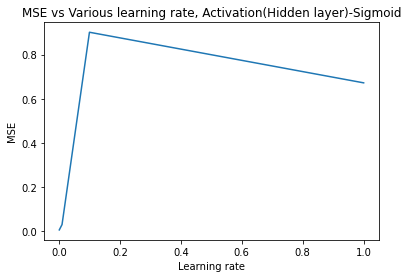

In [15]:
#for various learning rate
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    ytestSt = (ytest - meanY) / stdY

    epochs=1001
    lr = [0.001,0.01,0.1,1]
    error = [0,0,0,0]
    best = [1,1,1,1]

    activation = "sigmoid"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 2, lr[0], activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[0] = np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 2, lr[1], activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[1]= np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 2, lr[2], activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[2] = np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 2, lr[3], activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[3] = np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    tot = np.array(best)-np.array(error)
    plt.plot(lr,tot)
    plt.xlabel('Learning rate')
    plt.ylabel('MSE')
    plt.title('MSE vs Various learning rate, Activation(Hidden layer)-Sigmoid')

if __name__ == "__main__":
    main()

5. From the tested learning rates, we can tell that increasing learning rate improves the model. But for the same number of iteration but learning rate 0.001 to 0.01 the accuracy increases significantly. 

Cost after iteration 0: 1.000373
Cost after iteration 500: 0.039774
Cost after iteration 0: 1.002723
Cost after iteration 500: 0.015480
Cost after iteration 0: 1.002410
Cost after iteration 500: 0.007146
Cost after iteration 0: 1.020103
Cost after iteration 500: 0.003444
Cost after iteration 0: 1.023761
Cost after iteration 500: 0.003200
Cost after iteration 0: 0.998460
Cost after iteration 500: 0.003492


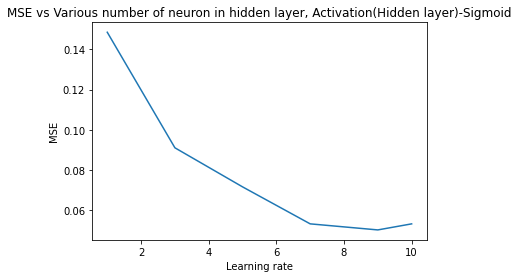

In [16]:
#effect of number of hidden layer
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    ytestSt = (ytest - meanY) / stdY

    epochs=1000
    lr =0.1
    n_n = [1,3,5,7,9,10]
    error = [0,0,0,0,0,0]

    activation = "sigmoid"
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, n_n[0], lr, activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[0] = np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, n_n[1], lr, activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[1]= np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, n_n[2], lr, activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[2] = np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, n_n[3], lr, activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[3] = np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, n_n[4], lr, activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[4] = np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, n_n[5], lr, activation,epochs, print_cost=True)
    ytrainHat = predict(parameters, xtrainSt, activation)
    error[5] = np.sqrt(((ytrainHat - ytrainSt) ** 2).mean())
    plt.plot(n_n,error)
    plt.xlabel('Learning rate')
    plt.ylabel('MSE')
    plt.title('MSE vs Various number of neuron in hidden layer, Activation(Hidden layer)-Sigmoid')
    #accuracy is the difference be
if __name__ == "__main__":
    main()

6.(a) If we change the number of neurons the weight matrix shape will change for example for this given system we have two features so weight matrix in first layer(hidden) would be [no of neurons,input feature] because it gets transposed when performing matrix multiplicaiton. So there will be no change in update rule only the shape of weight matrix will change. Update rule might change when the number of hidden layers changes.

(b)Based on final loss and plot for various neurons we can see that upto 9 neuron in the hidden layer works well but 10 neuron causes overfitting issue.(We validated based on test data as well)  

In [17]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T

    xtestSt = (xtest - meanX) / stdX
    ytestSt = (ytest - meanY) / stdY

    epochs=2000
    lr = 0.1
    activation = "sigmoid"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 1, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

    plot_cost(cost_tot, epochs)

    ytrainHat = predict(parameters, xtrainSt, activation)
 

    

Final loss 0.011058853932308403
W1 = [[-0.05940284  0.93593014]
 [-0.03118054 -1.32895919]]
b1 = [[-0.00092061]
 [ 0.11329721]]
W2 = [[ 1.36230765 -2.67966372]]
b2 = [[0.72072564]]
(49, 1)


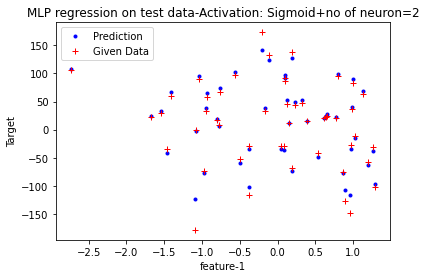

In [ ]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    xtestSt = xtestSt.T
    ytestSt = (ytest - meanY) / stdY
    ytestSt = ytestSt.T
    epochs=1000
    lr = 0.1
    activation = "sigmoid"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 2, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print(ytest.shape)
    #Back to original
    ytestHatSt = predict(parameters, xtestSt, activation)
    ytestHat = ytestHatSt*stdY+meanY
    plt.plot(X_test[:,0],ytestHat.T,'.',c='b',label='Prediction')
    plt.plot(X_test[:,0], Y_test,'+',c = 'r', label='Given Data')
    plt.legend()
    plt.xlabel('feature-1')
    plt.ylabel('Target')
    plt.title('MLP regression on test data-Activation: Sigmoid+no of neuron=2')

if __name__ == "__main__":
    main()

Final loss 0.013931298544539991
W1 = [[-0.03268014  1.2172965 ]
 [ 0.01974087  1.37702944]]
b1 = [[-0.15648864]
 [-0.20545097]]
W2 = [[1.56394521 2.20863884]]
b2 = [[-1.74871691]]
(49, 1)


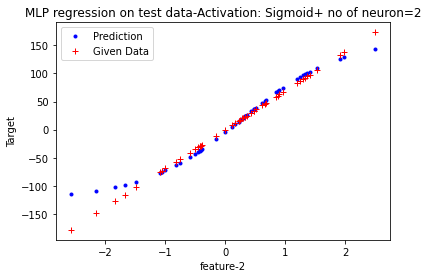

In [ ]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    xtestSt = xtestSt.T
    ytestSt = (ytest - meanY) / stdY
    ytestSt = ytestSt.T
    epochs=1000
    lr = 0.1
    activation = "sigmoid"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 2, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print(ytest.shape)
    #Back to original
    ytestHatSt = predict(parameters, xtestSt, activation)
    ytestHat = ytestHatSt*stdY+meanY
    plt.plot(X_test[:,1],ytestHat.T,'.',c='b',label='Prediction')
    plt.plot(X_test[:,1], Y_test,'+',c = 'r', label='Given Data')
    plt.legend()
    plt.xlabel('feature-2')
    plt.ylabel('Target')
    plt.title('MLP regression on test data-Activation: Sigmoid+ no of neuron=2')

if __name__ == "__main__":
    main()

Final loss 0.0028005402786450413
W1 = [[ 0.02144111  0.65538848]
 [-0.05819386  0.4236508 ]
 [-0.02066893  0.44207764]
 [ 0.06714452  0.23074232]
 [-0.02158241  0.7615038 ]
 [ 0.0105588  -0.9899019 ]
 [-0.08161437 -0.91367453]
 [-0.04331652 -0.40326163]
 [-0.13053132  0.54384179]]
b1 = [[-0.01816883]
 [-0.00882465]
 [-0.0084245 ]
 [-0.00306657]
 [-0.02751791]
 [ 0.0558628 ]
 [ 0.03860735]
 [ 0.00666821]
 [-0.01585109]]
W2 = [[ 0.69817251  0.41378572  0.4434898   0.2061164   0.85684906 -1.33411282
  -1.19519718 -0.45154945  0.54604552]]
b2 = [[-0.05017857]]
(49, 1)


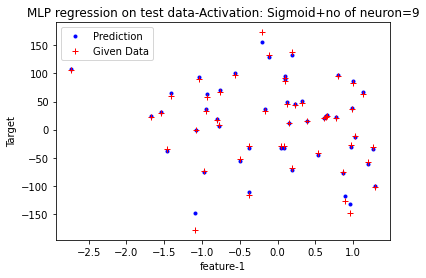

In [ ]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    xtestSt = xtestSt.T
    ytestSt = (ytest - meanY) / stdY
    ytestSt = ytestSt.T
    epochs=1000
    lr = 0.1
    activation = "sigmoid"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 9, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print(ytest.shape)
    #Back to original
    ytestHatSt = predict(parameters, xtestSt, activation)
    ytestHat = ytestHatSt*stdY+meanY
    plt.plot(X_test[:,0],ytestHat.T,'.',c='b',label='Prediction')
    plt.plot(X_test[:,0], Y_test,'+',c = 'r', label='Given Data')
    plt.legend()
    plt.xlabel('feature-1')
    plt.ylabel('Target')
    plt.title('MLP regression on test data-Activation: Sigmoid+no of neuron=9')

if __name__ == "__main__":
    main()

Final loss 0.0033017642505600137
W1 = [[ 0.07660861 -0.44431191]
 [-0.0998531  -0.95401476]
 [ 0.13991034  0.78185002]
 [ 0.01544728  0.37541568]
 [-0.05371718  0.23984864]
 [-0.1322545   0.8708329 ]
 [-0.02177441 -0.21512179]
 [ 0.09178764 -0.93173326]
 [ 0.19674734  0.15462232]]
b1 = [[ 0.00161874]
 [ 0.03027626]
 [-0.00978027]
 [ 0.00079088]
 [ 0.00112796]
 [-0.03353846]
 [-0.00097811]
 [ 0.03864397]
 [ 0.00181466]]
W2 = [[-0.43503325 -1.23662662  0.97015291  0.40144327  0.25840974  1.10595672
  -0.19169211 -1.17190467  0.17380881]]
b2 = [[0.0939052]]
(49, 1)


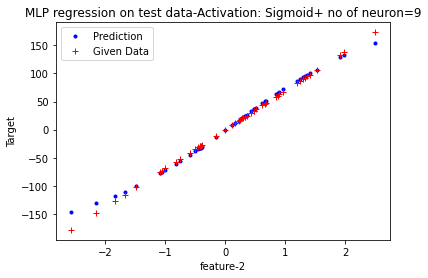

In [ ]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    xtestSt = xtestSt.T
    ytestSt = (ytest - meanY) / stdY
    ytestSt = ytestSt.T
    epochs=1000
    lr = 0.1
    activation = "sigmoid"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 9, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print(ytest.shape)
    #Back to original
    ytestHatSt = predict(parameters, xtestSt, activation)
    ytestHat = ytestHatSt*stdY+meanY
    plt.plot(X_test[:,1],ytestHat.T,'.',c='b',label='Prediction')
    plt.plot(X_test[:,1], Y_test,'+',c = 'r', label='Given Data')
    plt.legend()
    plt.xlabel('feature-2')
    plt.ylabel('Target')
    plt.title('MLP regression on test data-Activation: Sigmoid+ no of neuron=9')

if __name__ == "__main__":
    main()

tanh
Final loss 0.0010387095742308526
W1 = [[ 0.10685101 -0.345255  ]
 [ 0.16169504  0.06134815]
 [ 0.06013149 -0.30037505]
 [-0.13539234 -0.30718542]
 [ 0.01835649 -0.34665751]
 [-0.04477262  0.28276494]
 [-0.00576871 -0.33805394]
 [-0.17190079 -0.20813594]
 [-0.0156609   0.27166954]
 [ 0.03464933 -0.19324557]]
b1 = [[ 2.12655064e-02]
 [ 1.99892960e-03]
 [ 7.50424621e-03]
 [ 4.74846301e-05]
 [ 2.02429554e-02]
 [-4.28076952e-03]
 [ 1.50153989e-02]
 [-7.29217012e-03]
 [-1.93562103e-03]
 [-1.91834951e-03]]
W2 = [[-0.48709539  0.06562702 -0.39684848 -0.4229006  -0.52571138  0.3797992
  -0.49220808 -0.27209447  0.35865288 -0.20094525]]
b2 = [[0.03020749]]
(49, 1)


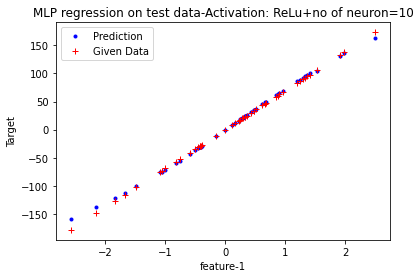

In [ ]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    xtestSt = xtestSt.T
    ytestSt = (ytest - meanY) / stdY
    ytestSt = ytestSt.T
    epochs=1000
    lr = 0.1
    activation = "tanh"
    print(activation)

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 10, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print(ytest.shape)
    #Back to original
    ytestHatSt = predict(parameters, xtestSt, activation)
    ytestHat = ytestHatSt*stdY+meanY
    plt.plot(X_test[:,1],ytestHat.T,'.',c='b',label='Prediction')
    plt.plot(X_test[:,1], Y_test,'+',c = 'r', label='Given Data')
    plt.legend()
    plt.xlabel('feature-1')
    plt.ylabel('Target')
    plt.title('MLP regression on test data-Activation: ReLu+no of neuron=10')

if __name__ == "__main__":
    main()

Final loss 0.003024234796251835
W1 = [[ 0.10892147 -0.90406783]
 [-0.06522937 -0.34103186]
 [-0.08221388 -0.21916481]
 [ 0.00762999  0.62728208]
 [-0.06347209  0.07114625]
 [-0.00900939  0.3457078 ]
 [ 0.15258817  0.59216131]
 [-0.05353983  0.94714096]
 [ 0.12134853 -0.23082587]
 [-0.06530731 -0.90593241]]
b1 = [[ 3.87809927e-02]
 [-5.83844771e-04]
 [-8.06264586e-04]
 [-8.31316888e-03]
 [ 1.59118257e-04]
 [-5.02212516e-04]
 [-2.12193249e-03]
 [-4.33179276e-02]
 [ 7.64796313e-06]
 [ 2.95382914e-02]]
W2 = [[-1.14112639 -0.33062967 -0.21400416  0.71113695  0.08482569  0.36786448
   0.6660535   1.25208451 -0.22722283 -1.14692726]]
b2 = [[0.022438]]
(49, 1)


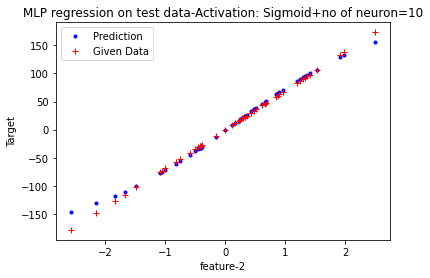

In [ ]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    xtestSt = xtestSt.T
    ytestSt = (ytest - meanY) / stdY
    ytestSt = ytestSt.T
    epochs=1000
    lr = 0.1
    activation = "sigmoid"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 10, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print(ytest.shape)
    #Back to original
    ytestHatSt = predict(parameters, xtestSt, activation)
    ytestHat = ytestHatSt*stdY+meanY
    plt.plot(X_test[:,1],ytestHat.T,'.',c='b',label='Prediction')
    plt.plot(X_test[:,1], Y_test,'+',c = 'r', label='Given Data')
    plt.legend()
    plt.xlabel('feature-2')
    plt.ylabel('Target')
    plt.title('MLP regression on test data-Activation: Sigmoid+no of neuron=10')

if __name__ == "__main__":
    main()

7.(a)Since update rule need to multiply the derivativ of the activation functions, so we need to change the update rule based on activation function as well. 

(b)The change occurs in the backpropagation during chain rule and in forward propagation when we need to use a = g(z).So where we need to use the activation function and its derivative we need to change to achieve this experiement.

(c)Based on the true label and the prediction we can tell that ReLu works slightly better for our given system compared to sigmoid and tanh. 


Final loss 0.0018053774401740228
W1 = [[ 0.07998565 -0.38866194]
 [-0.13951845  0.26115593]
 [ 0.09300713  0.35004437]
 [ 0.0835757  -0.28799793]
 [ 0.11686393  0.37667678]]
b1 = [[ 0.05534921]
 [ 0.00195971]
 [ 0.01249209]
 [-0.0022979 ]
 [-0.00298365]]
W2 = [[-1.00113744  0.29212753  0.52826359 -0.33889287  0.91688803]]
b2 = [[0.0456287]]
(49, 1)


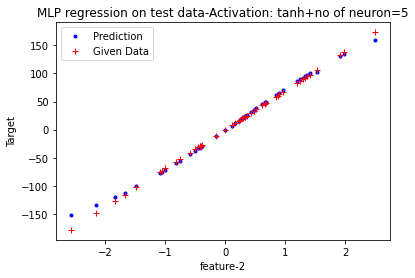

In [ ]:
def main():
    xtrain = np.array(X_train)
    ytrain = np.array(Y_train)
    xtest = np.array(X_test)
    ytest = np.array(Y_test)
    # take mean and standard deviation of features of the training set for standardization
    meanX = np.mean(xtrain, axis=0)
    stdX = np.std(xtrain, axis=0)
    # standardize features of the trainig set
    xtrainSt = (xtrain - meanX) / stdX
    xtrainSt = xtrainSt.T
    meanY = np.mean(ytrain, axis=0)
    stdY = np.std(ytrain, axis=0)
    ytrainSt = (ytrain - meanY) / stdY
    ytrainSt = ytrainSt.T
    xtestSt = (xtest - meanX) / stdX
    xtestSt = xtestSt.T
    ytestSt = (ytest - meanY) / stdY
    ytestSt = ytestSt.T
    epochs=1000
    lr = 0.1
    activation = "tanh"

    parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 5, lr, activation,epochs, print_cost=True)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print(ytest.shape)
    #Back to original
    ytestHatSt = predict(parameters, xtestSt, activation)
    ytestHat = ytestHatSt*stdY+meanY
    plt.plot(X_test[:,1],ytestHat.T,'.',c='b',label='Prediction')
    plt.plot(X_test[:,1], Y_test,'+',c = 'r', label='Given Data')
    plt.legend()
    plt.xlabel('feature-2')
    plt.ylabel('Target')
    plt.title('MLP regression on test data-Activation: tanh+no of neuron=5')

if __name__ == "__main__":
    main()

Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Cost after iteration 0: 0.990263
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (5, 99)
Z1.dtype =  float64
A1 =  (5, 99)
Z1 =  (

Text(0.5, 1.0, 'MLP regression on test data-Activation: ReLu+no of neuron=5')

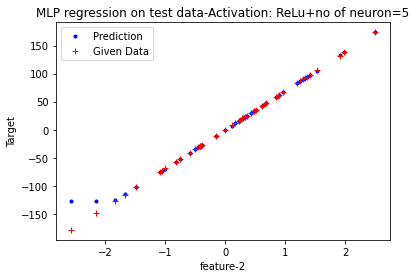

In [59]:
xtrain = np.array(X_train)
ytrain = np.array(Y_train)
xtest = np.array(X_test)
ytest = np.array(Y_test)
# take mean and standard deviation of features of the training set for standardization
meanX = np.mean(xtrain, axis=0)
stdX = np.std(xtrain, axis=0)
# standardize features of the trainig set
xtrainSt = (xtrain - meanX) / stdX
xtrainSt = xtrainSt.T
meanY = np.mean(ytrain, axis=0)
stdY = np.std(ytrain, axis=0)
ytrainSt = (ytrain - meanY) / stdY
ytrainSt = ytrainSt.T
xtestSt = (xtest - meanX) / stdX
xtestSt = xtestSt.T
ytestSt = (ytest - meanY) / stdY
ytestSt = ytestSt.T
epochs=1000
lr = 0.1
activation = "relu"

parameters, cost_tot = MLP_model(xtrainSt, ytrainSt, 5, lr, activation,epochs, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print(ytest.shape)
#Back to original
ytestHatSt = predict(parameters, xtestSt, activation)
ytestHat = ytestHatSt*stdY+meanY
plt.plot(X_test[:,1],ytestHat.T,'.',c='b',label='Prediction')
plt.plot(X_test[:,1], Y_test,'+',c = 'r', label='Given Data')
plt.legend()
plt.xlabel('feature-2')
plt.ylabel('Target')
plt.title('MLP regression on test data-Activation: ReLu+no of neuron=5')